"I/we certify that the code and data in this assignment were generated independently, using only the tools and resources defined in the course and that I/we did not receive any external help, coaching or contributions during the production of this work."

This file contains the following two solved envirnoment codes:


1.   DQN on Grid Environment
2.   Double DQN on Grid Environment



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
import tensorflow as tf
import random, math, time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
import matplotlib
import tensorflow.keras.backend as K

In [2]:
class KitchenGridEnvironment(gym.Env):
    metadata = { 'render.modes': [] }
    
    def __init__(self):
        self.observation_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 20
        
    def reset(self):
        self.timestep = 0
        self.ant_pos = [0,0]
        self.goal_pos = [3, 3]
        self.sugar1 = [1, 1]   #reward 1
        self.sugar2 = [3,1]  #reward 2
        self.sugar3 = [1,3]   #reward 3
        self.pest = [0,2]   #reward 4
        self.sugar1_cnt=0
        self.sugar2_cnt=0
        self.sugar3_cnt=0
        self.pest_cnt = 0
        self.cummulative_reward=0            #cummulative reward
        self.state = np.zeros((4,4))
        self.state[tuple(self.ant_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        observation = self.state.flatten()
        return observation
    
    def step(self, action):
        mov_rew=0;
        if action == 0:
          self.ant_pos[0] += 1
          if self.ant_pos[0]<4: mov_rew= 1
          else: mov_rew=-1

        if action == 1:
          self.ant_pos[0] -= 1
          mov_rew=-1

        if action == 2:
          self.ant_pos[1] += 1
          if self.ant_pos[1]<4: mov_rew=1
          else: mov_rew=-1

        if action == 3:
          self.ant_pos[1] -= 1
          mov_rew=-1
          
        self.ant_pos = np.clip(self.ant_pos, 0, 3)
        self.state = np.zeros((4,4))
        
        self.state[tuple(self.goal_pos)] = 0.5
        self.state[tuple(self.ant_pos)] = 1
        observation = self.state.flatten()
        
        reward = 0
        if (self.ant_pos == self.goal_pos).all():
          reward = 50
        elif (self.ant_pos == self.sugar1).all() and self.sugar1_cnt == 0:
          reward=10;
          self.sugar1_cnt = 1
        elif (self.ant_pos == self.sugar2).all() and self.sugar2_cnt == 0:
          reward = 10
          self.sugar2_cnt = 1
        elif (self.ant_pos == self.sugar3).all() and self.sugar3_cnt == 0:
          reward = 10
          self.sugar3_cnt = 1
        elif (self.ant_pos == self.pest).all() and self.pest_cnt == 0:
          reward = -10
          self.pest_cnt == 1
        
        reward += mov_rew
        self.cummulative_reward += reward
        self.timestep += 1
        done = True if self.timestep >= self.max_timesteps or (self.ant_pos == self.goal_pos).all() else False
        info = "Current postion : "+ str(self.ant_pos[0])+","+str(self.ant_pos[1])+ " reward: "+ str(reward) + " Cummulative reward: "+ str(self.cummulative_reward)
        
        return observation, reward, done, info
        
    def render(self):
        plt.imshow(self.state)

In [3]:
class AntAgent:
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space

  def step(self, observation):
    return np.random.choice(self.action_space.n)

In [4]:
class ReplayBuffer(object):

    def __init__(self, size):
      self.size = size
      self.buffer = []
      self.idx = 0

    def add(self,state,action,reward,newstate,done):
      if len(self.buffer) >= self.size:
        self.buffer[self.idx] = (state,action,reward,newstate,done)
      else:
          self.buffer.append((state,action,reward,newstate,done))

      self.idx+=1

      if self.idx == self.size:
        self.idx = 0

    def sample(self, batch_size):
      size_sample = min(len(self.buffer), batch_size)
      return random.sample(self.buffer, size_sample)
      

This class is for DQN.

In [31]:
class DQLearning:
    def __init__(self,env,agent):
        self.env = env
        self.agent = agent
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.Depsilon_decay = []
        self.dqn_reward_train = []
        self.Dlosses= []
        
    def greedy_act_max(self,obs):
        return np.argmax(self.model_target(obs))
        
    def policy(self,epsilon,obs):
        return random.choices([np.random.randint(self.action_space.n), self.greedy_act_max(obs)], weights =(epsilon,1-epsilon),k=1)[0]
    
    def max_Qval(self,state):
        return np.argmax(self.target_qtable, axis=1)[state]

    def learning_network_model(self,lr,input_state_dim,output_action_dim):
        model = Sequential()
        model.add(Dense(64, input_dim=input_state_dim, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(output_action_dim, activation='linear'))
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
        model.compile(loss='mse', optimizer=opt)
        return model
        
    def train(self,episodes,gamma,alfa_lr,decay_factor,replay_buffer_size=2000,minibatch_size=200):
        epsilon = 1
        episodes = episodes
        rbuffer = ReplayBuffer(replay_buffer_size)
        obs = self.env.reset()
        obs_size = 16
        action_size = self.env.action_space.n
        self.model_policy = self.learning_network_model(alfa_lr,obs_size,action_size)
        self.model_target = self.learning_network_model(alfa_lr,obs_size,action_size)
        self.model_target.set_weights(self.model_policy.get_weights())
       
        for eps_n in np.arange(episodes):
            obs = self.env.reset()
            done_iter = False
            self.Depsilon_decay.append(epsilon)
            print("The episode no. is " + str(eps_n))
            cumm_reward=0
            step_no=0

            while not done_iter:
              agent_pnow = np.argmax(obs)
              action = int(self.policy(epsilon,obs.reshape(1,obs_size)))
              obs_next, reward, done_iter, info = self.env.step(action)
              cumm_reward += (gamma**(step_no))*reward

              rbuffer.add(obs.reshape(1,obs_size),action,reward,obs_next.reshape(1,obs_size),done_iter)
              step_no+=1
              obs = obs_next
              
              batch = rbuffer.sample(minibatch_size)
              batch_size = len(batch)
              if batch_size == minibatch_size:
                curr_pos_batch = np.array([ sample_state[0] for sample_state in batch ])
                if step_no%5==0:
                  state_next = tf.stack([s2 for (s1,a,r,s2,d) in batch])
                  curr_state = tf.stack([s1 for (s1,a,r,s2,d) in batch])
                  action_ = tf.stack([a for (s1,a,r,s2,d) in batch])
                  reward_ = tf.cast(tf.stack([r for (s1,a,r,s2,d) in batch]), tf.float32)
                  done_ = tf.cast(tf.stack([d for (s1,a,r,s2,d) in batch]), tf.float32)
                  if True:
                    next_q = self.model_target.predict(tf.reshape(state_next,(minibatch_size,obs_size)))
                    #print("7")
                    max_q = tf.math.reduce_max(next_q, axis=1, keepdims=False)
                    #print("8")
                    #print("9")
                    target_y = reward_  + gamma*(1-done_)*max_q
                    #print("10")

                  #print("11")
                  #print("12")
                  x = tf.reshape(curr_state,(minibatch_size,obs_size))
                  #print("13")
                  q_predicted = self.model_policy.predict(tf.reshape(curr_state,(minibatch_size,obs_size)))
                  dept_action = tf.expand_dims(action_, 1)    #adding depth dimension to the action tensor
                  #print("14", b_2)
                  index_tensor = tf.expand_dims(tf.range(tf.shape(action_)[0]), 1)   #adding depth dimension to a new tensor with shape as action tensor
                  #print("15", range)
                  index_to_update = tf.concat([index_tensor, dept_action], 1)        #adding depth dimension to a new tensor with shape as action tensor
                  #print("16")
                  y = tf.tensor_scatter_nd_update(q_predicted, index_to_update, target_y)
                  #print("14")
                  #print(tf.shape(x) ,tf.shape(y))
                  sequential_model = self.model_policy.fit(x, y, batch_size=minibatch_size, epochs=1, verbose=0)
                  self.Dlosses.append(sequential_model.history['loss'])
                  #print("16")
            
            if epsilon > 0.001 : epsilon = epsilon*decay_factor
            self.dqn_reward_train.append(cumm_reward)
            print("cummulative reward is " + str(cumm_reward) + " for episode no. " + str(eps_n + 1)  )  

            #every c steps set your target weights to the model policy weights
            if eps_n%5==0:
              self.model_target.set_weights(self.model_policy.get_weights())

            
            

In [32]:
env = KitchenGridEnvironment()
agent = AntAgent(env)

epsilon = 1
number_of_episodes = 2000
decay_factor = round((0.01/epsilon)**(1/number_of_episodes),4)

dql = DQLearning(env,agent)

Training DQN on the GRID Environment

In [33]:
dql.train(episodes = number_of_episodes,gamma = 0.99, alfa_lr = 0.0001, decay_factor=decay_factor)

The episode no. is 0
cummulative reward is 5.92662822184305 for episode no. 1
The episode no. is 1
cummulative reward is 9.840067995698377 for episode no. 2
The episode no. is 2
cummulative reward is -10.709076846836583 for episode no. 3
The episode no. is 3
cummulative reward is 17.330396786903894 for episode no. 4
The episode no. is 4
cummulative reward is -20.7147423448199 for episode no. 5
The episode no. is 5
cummulative reward is -12.893516747620133 for episode no. 6
The episode no. is 6
cummulative reward is 5.722614584717247 for episode no. 7
The episode no. is 7
cummulative reward is -1.1507026689905828 for episode no. 8
The episode no. is 8
cummulative reward is 6.4447442391093634 for episode no. 9
The episode no. is 9
cummulative reward is 2.992476609285382 for episode no. 10
The episode no. is 10
cummulative reward is -3.7839185730684655 for episode no. 11
The episode no. is 11
cummulative reward is 7.838773065757282 for episode no. 12
The episode no. is 12
cummulative rewa

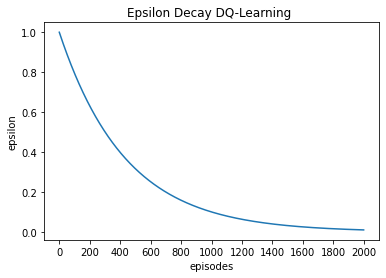

In [38]:
#Plotting Epsilon Decay DQ-Learning 
plt.plot(dql.Depsilon_decay,mfc='pink') 
plt.xticks(range(0,len(dql.Depsilon_decay)+1, 200)) 

plt.ylabel('epsilon')
plt.xlabel('episodes') 
plt.title("Epsilon Decay DQ-Learning ") 
plt.show()

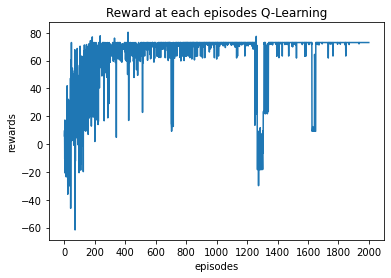

In [37]:
#Reward at each iteration DQ-Learning
plt.plot(dql.dqn_reward_train) 
plt.xticks(range(0,len(dql.dqn_reward_train)+1,200)) 

plt.ylabel('rewards')
plt.xlabel('episodes') 
plt.title("Reward at each episodes Q-Learning") 
plt.show()

Running the agent for 10 episodes using the trained Q model using greedy policy shows the below reward graph

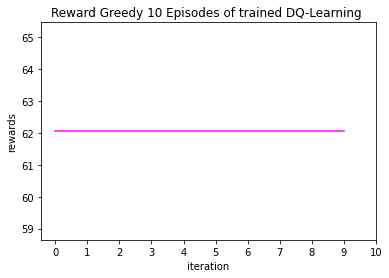

In [39]:
#evaluate Q learning
gamma = 0.95

reward_DQlearning_10ep = []
for i in np.arange(10):
    obs = dql.env.reset()
    done_iter = False
    print(i,end="\r")
    cumm_reward=0
    step_no = 0
    while not done_iter:
        action = int(dql.greedy_act_max(obs.reshape(1,16)))
        obs_next, reward, done_iter, info = dql.env.step(action)
        cumm_reward += (gamma**(step_no))*reward
        obs = obs_next
        # done_iter = done
        step_no += 1
    reward_DQlearning_10ep.append(cumm_reward)

plt.plot(reward_DQlearning_10ep,color='magenta') 
plt.xticks(range(0,len(reward_DQlearning_10ep)+1, 1)) 

plt.ylabel('rewards')
plt.xlabel('iteration') 
plt.title("Reward Greedy 10 Episodes of trained DQ-Learning ") 
plt.show()

Below is the training of Double DQN on Grid Environment

In [17]:
class DDQLearning:
    def __init__(self,env,agent):
        self.env = env
        self.agent = agent
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.DDepsilon_decay = []
        self.ddqn_reward_train = []
        self.DDlosses = []
        
    def greedy_act_max(self,obs):
        return np.argmax(self.model_target(obs))
        
    def policy(self,epsilon,obs):
        return random.choices([np.random.randint(self.action_space.n), self.greedy_act_max(obs)], weights =(epsilon,1-epsilon),k=1)[0]
    
    def max_Qval(self,state):
        return np.argmax(self.target_qtable, axis=1)[state]

    def learning_network_model(self,lr,input_state_dim,output_action_dim):
        model = Sequential()
        model.add(Dense(64, input_dim=input_state_dim, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(output_action_dim, activation='linear'))
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
        model.compile(loss='mse', optimizer=opt)
        return model
        
    def train(self,episodes,gamma,alfa_lr,decay_factor,replay_buffer_size=2000,minibatch_size=200):
        epsilon = 1
        episodes = episodes
        rbuffer = ReplayBuffer(replay_buffer_size)
        obs = self.env.reset()
        obs_size = 16
        action_size = self.env.action_space.n
        self.model_policy = self.learning_network_model(alfa_lr,obs_size,action_size)
        self.model_target = self.learning_network_model(alfa_lr,obs_size,action_size)
        self.model_target.set_weights(self.model_policy.get_weights())
       
        for eps_n in np.arange(episodes):
            obs = self.env.reset()
            done_iter = False
            self.DDepsilon_decay.append(epsilon)
            print("The episode no. is " + str(eps_n))
            cumm_reward=0
            step_no=0

            while not done_iter:
              agent_pnow = np.argmax(obs)
              action = int(self.policy(epsilon,obs.reshape(1,obs_size)))
              obs_next, reward, done_iter, info = self.env.step(action)
              cumm_reward += (gamma**(step_no))*reward

              rbuffer.add(obs.reshape(1,obs_size),action,reward,obs_next.reshape(1,obs_size), done_iter)
              step_no+=1
              obs = obs_next
              
              batch = rbuffer.sample(minibatch_size)
              batch_size = len(batch)
              if batch_size == minibatch_size:
                curr_pos_batch = np.array([ sample_state[0] for sample_state in batch ])
                if step_no%5==0:
                  state_next = tf.stack([s2 for (s1,a,r,s2,d) in batch])
                  curr_state = tf.stack([s1 for (s1,a,r,s2,d) in batch])
                  action_ = tf.stack([a for (s1,a,r,s2,d) in batch])
                  reward_ = tf.cast(tf.stack([r for (s1,a,r,s2,d) in batch]), tf.float32)
                  done_ = tf.cast(tf.stack([d for (s1,a,r,s2,d) in batch]), tf.float32)
                  if True:
                    next_q = self.model_policy.predict(tf.reshape(state_next,(minibatch_size,obs_size)))
                    #print("7")
                    max_a = tf.math.argmax(next_q, 1)
                    #print("8")
                    double_q = self.model_target.predict(tf.reshape(state_next,(minibatch_size,obs_size)))
                    #print("9")
                    target_y = reward_  + gamma*(1-done_)*(tf.gather(double_q[0], max_a).numpy())
                    #print("10")
 
                  #print("11")
                  #print("12")
                  x = tf.reshape(curr_state,(minibatch_size,obs_size))
                  #print("13")
                  q_predicted = self.model_policy.predict(tf.reshape(curr_state,(minibatch_size,obs_size)))
                  dept_action = tf.expand_dims(action_, 1)    #adding depth dimension to the action tensor
                  #print("14", b_2)
                  index_tensor = tf.expand_dims(tf.range(tf.shape(action_)[0]), 1)   #adding depth dimension to a new tensor with shape as action tensor
                  #print("15", range)
                  index_to_update = tf.concat([index_tensor, dept_action], 1)        #adding depth dimension to a new tensor with shape as action tensor
                  #print("16")
                  y = tf.tensor_scatter_nd_update(q_predicted, index_to_update, target_y)
                  #print("14")
                  #print(tf.shape(x) ,tf.shape(y))
                  sequential_model = self.model_policy.fit(x, y, batch_size=minibatch_size, epochs=1, verbose=0)
                  self.DDlosses.append(sequential_model.history['loss'])
                  #print("16")

            if epsilon > 0.001 : epsilon = epsilon*decay_factor
            self.ddqn_reward_train.append(cumm_reward)
            print("cummulative reward is " + str(cumm_reward) + " for episode no. " + str(eps_n - 1)  )  

            #every c steps set your target weights to the model policy weights
            if eps_n%5==0:
              self.model_target.set_weights(self.model_policy.get_weights())


            
            

In [18]:
env = KitchenGridEnvironment()
agent = AntAgent(env)

epsilon = 1
number_of_episodes = 2000
decay_factor = round((0.01/epsilon)**(1/number_of_episodes),4)

ddql = DDQLearning(env,agent)

In [19]:
ddql.train(episodes = number_of_episodes,gamma = 0.99, alfa_lr = 0.0001, decay_factor=decay_factor)

The episode no. is 0
cummulative reward is -12.065761103854731 for episode no. -1
The episode no. is 1
cummulative reward is 17.76201645555618 for episode no. 0
The episode no. is 2
cummulative reward is -40.47072667343408 for episode no. 1
The episode no. is 3
cummulative reward is 59.93790045155748 for episode no. 2
The episode no. is 4
cummulative reward is 9.158070914900614 for episode no. 3
The episode no. is 5
cummulative reward is -10.992960895546858 for episode no. 4
The episode no. is 6
cummulative reward is 64.41754321646286 for episode no. 5
The episode no. is 7
cummulative reward is -3.567300138496048 for episode no. 6
The episode no. is 8
cummulative reward is 4.169687444519914 for episode no. 7
The episode no. is 9
cummulative reward is 23.189261537725354 for episode no. 8
The episode no. is 10
cummulative reward is 7.00303792519323 for episode no. 9
The episode no. is 11
cummulative reward is -3.1898578316199417 for episode no. 10
The episode no. is 12
cummulative reward

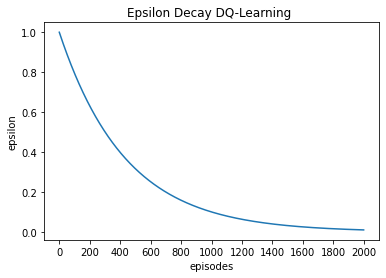

In [40]:
#Plotting Epsilon Decay DQ-Learning 
plt.plot(ddql.DDepsilon_decay,mfc='pink') 
plt.xticks(range(0,len(ddql.DDepsilon_decay)+1, 200)) 

plt.ylabel('epsilon')
plt.xlabel('episodes') 
plt.title("Epsilon Decay DQ-Learning ") 
plt.show()

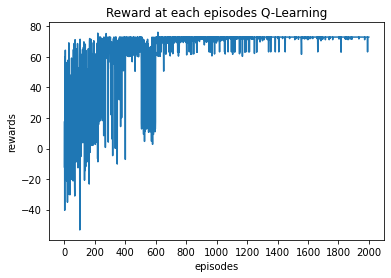

In [41]:
#Reward at each iteration DQ-Learning
plt.plot(ddql.ddqn_reward_train) 
plt.xticks(range(0,len(ddql.ddqn_reward_train)+1,200)) 

plt.ylabel('rewards')
plt.xlabel('episodes') 
plt.title("Reward at each episodes Q-Learning") 
plt.show()

Running the agent for 10 episodes using the  trained double Q model using greedy policy shows the below reward graph

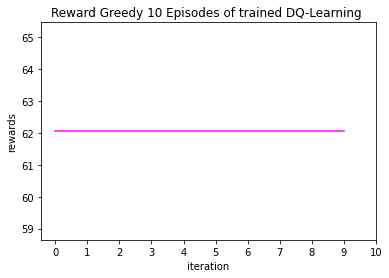

In [42]:
#evaluate Q learning
gamma = 0.95

reward_DQlearning_10ep = []
for i in np.arange(10):
    obs = ddql.env.reset()
    done_iter = False
    print(i,end="\r")
    cumm_reward=0
    step_no = 0
    while not done_iter:
        action = int(ddql.greedy_act_max(obs.reshape(1,16)))
        obs_next, reward, done_iter, info = ddql.env.step(action)
        cumm_reward += (gamma**(step_no))*reward
        obs = obs_next
        # done_iter = done
        step_no += 1
    reward_DQlearning_10ep.append(cumm_reward)

plt.plot(reward_DQlearning_10ep,color='magenta') 
plt.xticks(range(0,len(reward_DQlearning_10ep)+1, 1)) 

plt.ylabel('rewards')
plt.xlabel('iteration') 
plt.title("Reward Greedy 10 Episodes of trained DQ-Learning ") 
plt.show()

Below is the reward model obtained from DQN and Double DQN.
Magneta is DQN
Yellow is Double DQN

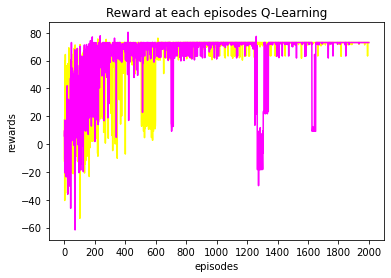

In [43]:
#Reward at each iteration DQ-Learning
plt.plot(ddql.ddqn_reward_train ,color='yellow') 
plt.plot(dql.dqn_reward_train,color='magenta') 
plt.xticks(range(0,len(ddql.ddqn_reward_train)+1, 200)) 

plt.ylabel('rewards')
plt.xlabel('episodes') 
plt.title("Reward at each episodes Q-Learning") 
plt.show()